==============================================
1. Importar librerías
==============================================

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo de gráficos
sns.set(style="whitegrid")

================================================
2. Cargar dataset
================================================

In [33]:
df = pd.read_csv("D:/PROGRAMAS/online_sales_limpio.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

C:\Users\TEROS\AppData\Local\Temp\ipykernel_3552\1638621199.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')


==============================================
3. Limpieza de datos
==============================================

In [34]:
# Se imputan valores faltantes en columnas categóricas con "Unknown"
# Se extraen componentes útiles desde la fecha (hora, día, mes)

for col in ['Country', 'PaymentMethod', 'Category', 'WarehouseLocation']:
    df[col] = df[col].fillna('Unknown')

df['Hour'] = df['InvoiceDate'].dt.hour
df['Day'] = df['InvoiceDate'].dt.day
df['Month'] = df['InvoiceDate'].dt.month
df.drop(columns=['InvoiceDate'], inplace=True)

==============================================
4. Análisis exploratorio (EDA)
==============================================

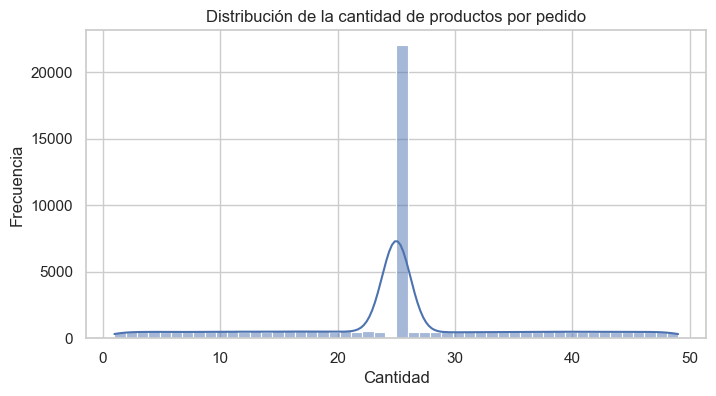

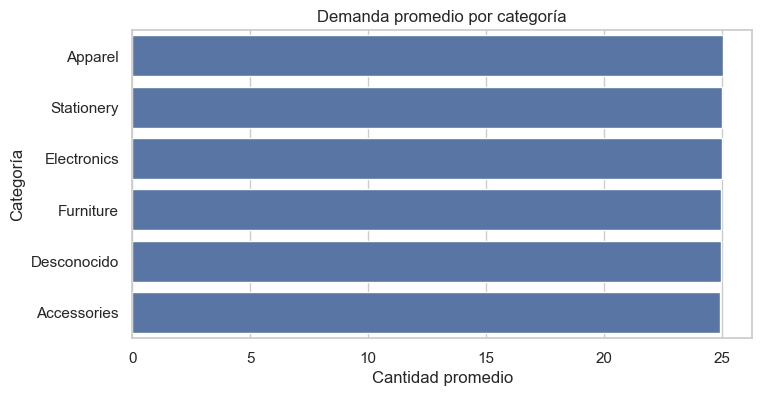

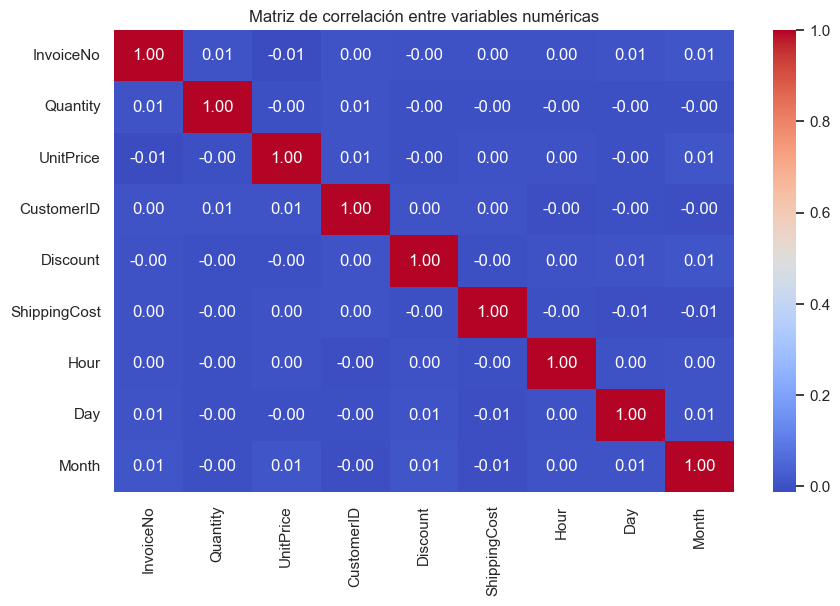

In [35]:
# 4.1. Distribución de cantidad de productos por pedido
plt.figure(figsize=(8,4))
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title('Distribución de la cantidad de productos por pedido')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')
plt.show()

# 4.2. Demanda promedio por categoría
plt.figure(figsize=(8,4))
category_avg = df.groupby('Category')['Quantity'].mean().sort_values(ascending=False)
sns.barplot(x=category_avg.values, y=category_avg.index)
plt.title('Demanda promedio por categoría')
plt.xlabel('Cantidad promedio')
plt.ylabel('Categoría')
plt.show()

# 4.3. Correlación entre variables numéricas
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

================================================
5. Ingeniería de características
================================================

In [36]:
# Se crean nuevas columnas que representan el comportamiento del precio real.
# - Precio con descuento
# - Precio final con envío
# - Si el pedido fue hecho en fin de semana

df['EffectivePrice'] = df['UnitPrice'] * (1 - df['Discount'])
df['PriceWithShipping'] = df['EffectivePrice'] + df['ShippingCost']
df['IsWeekend'] = (df['Day'] % 7 >= 5).astype(int)

# ==============================================
# 🎯 6. Variable objetivo: promedio por categoría
# ==============================================

In [37]:
df_grouped = df.groupby('Category')['Quantity'].mean().reset_index()
df_grouped.rename(columns={'Quantity': 'AvgQuantity'}, inplace=True)
df = df.merge(df_grouped, on='Category', how='left')

==============================================
7. Selección de variables y codificación
==============================================

In [39]:
features = [
    'UnitPrice', 'Discount', 'ShippingCost', 'Category',
    'PaymentMethod', 'SalesChannel', 'EffectivePrice',
    'PriceWithShipping', 'IsWeekend'
]

X = df[features].copy()
y = df['AvgQuantity'].copy()

for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


==============================================
8. División de datos
==============================================

In [40]:
# Se separan los datos para entrenamiento (80%) y prueba (20%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

==============================================
9. Entrenamiento del modelo (XGBoost)
==============================================

In [41]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


==============================================
9. Evaluación del modelo
==============================================

In [43]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📈 Evaluación del modelo:")
print(f"MAE:  {mae:.7f}")
print(f"RMSE: {rmse:.7f}")
print(f"R²:   {r2:.7f}")

📈 Evaluación del modelo:
MAE:  0.0000889
RMSE: 0.0001926
R²:   0.9999643


==============================================
11. Comparación visual: predicción vs realidad
==============================================

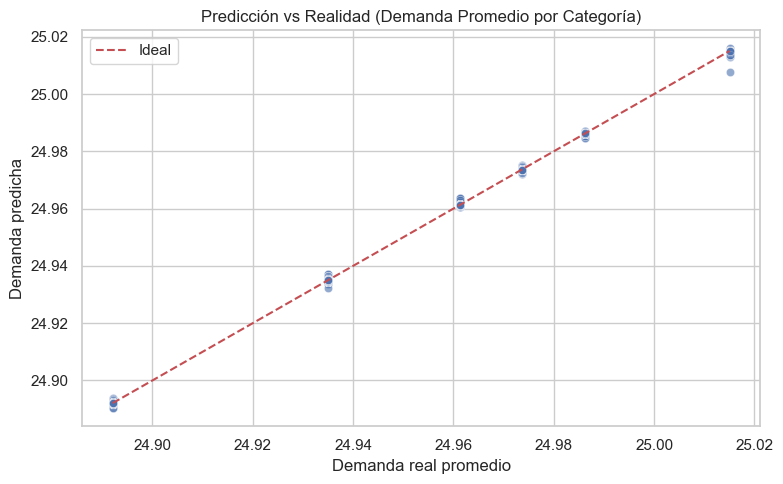

In [44]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Demanda real promedio")
plt.ylabel("Demanda predicha")
plt.title("Predicción vs Realidad (Demanda Promedio por Categoría)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
import joblib

# Exportar el modelo
joblib.dump(model, 'modelo_demanda.pkl')

# Exportar las columnas usadas
joblib.dump(features, 'features.pkl')

['features.pkl']